In [65]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
from matplotlib import pyplot as plt
from koala.pointsets import generate_random
from koala.example_graphs import generate_hex_square_oct, generate_tri_non
from koala import plotting as pl
from koala.voronization import generate_lattice
from koala.graph_color import color_lattice
from koala.hamiltonian import generate_majorana_hamiltonian
from koala.flux_finder import fluxes_from_bonds, fluxes_to_labels, n_to_ujk_flipped, find_flux_sector
from numpy import linalg as la
import numpy as np
from tqdm import tqdm
import matplotlib
from koala.lattice import cut_boundaries
matplotlib.rcParams.update({'font.size': 12, 'text.usetex': True, 'font.family': 'serif', 'font.serif': ['Computer Modern'], 'figure.figsize': (10,10)})

In [75]:
# define the lattice system
number_of_plaquettes = 500
plaquette_range = 10

# keep finding new lattices until you get one with a good range of plaquette sizes! (there is definitely a beter way to do this)
number_of_plaque_sizes = 0
tested = 0
while number_of_plaque_sizes < plaquette_range :
    tested += 1
    points = generate_random(number_of_plaquettes)
    lattice = generate_lattice(points)
    all_sides = np.array([lattice.plaquettes[n].n_sides for n in range(len(lattice.plaquettes))])
    number_of_plaque_sizes = len(np.unique(all_sides))

# lattice = generate_tri_non(21)


lattice = cut_boundaries(lattice)



# color the lattice
coloring = color_lattice(lattice)
print(f'We tested {tested} lattices')




We tested 16 lattices


In [86]:
ujk_init = np.full(lattice.n_edges, 1)
J = np.array([1,1,1])
all_sides = np.array([lattice.plaquettes[n].n_sides for n in range(len(lattice.plaquettes))])
target_flux = np.int0(-((1j)**all_sides).real -(1j**all_sides).imag)
ujk = find_flux_sector(lattice,target_flux,ujk_init)
# ujk = ujk_init
# find fluxes
fluxes = fluxes_from_bonds(lattice, ujk)



Text(0.5, 1.0, 'Distribution of n-gons in lattice')

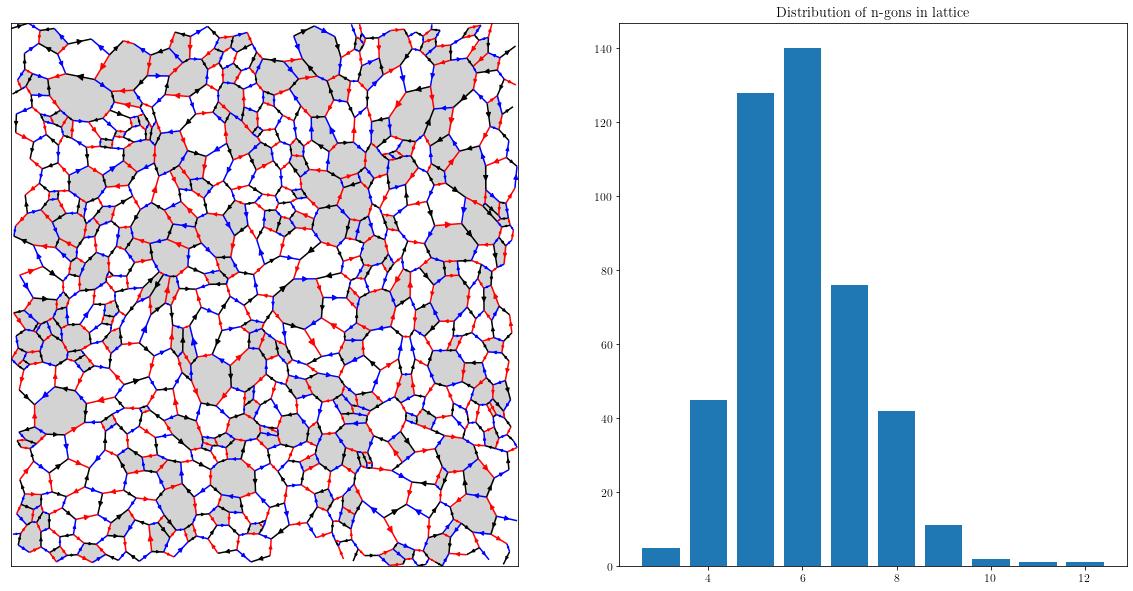

In [87]:


# plot it
fig, axes = plt.subplots(1,2,figsize = (20,10))
ax, ax2 = axes
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
pl.plot_edges(lattice, ax= ax,labels=coloring, directions=ujk)
pl.plot_plaquettes(lattice, ax= ax, labels = fluxes_to_labels(fluxes), color_scheme=np.array(['w','lightgrey']))
# pl.plot_edge_indices(lattice)
# ax.set_title(f'{lattice.n_plaquettes} plaquettes, {2**(lattice.n_plaquettes -1):.1E} combinations')

# find how many n-gons there are and plot that

all_centers = np.array([lattice.plaquettes[n].center for n in range(len(lattice.plaquettes))])
# for n in range(all_sides.__len__()):
#     ax.text(all_centers[n,0], all_centers[n,1], all_sides[n])
counts = np.bincount(all_sides)
ax2.bar(np.arange(len(counts))[3:], counts[3:])
ax2.set_title('Distribution of n-gons in lattice')


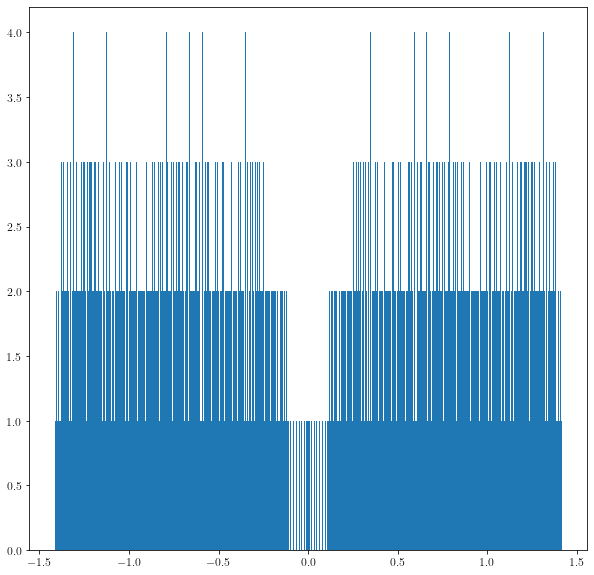

In [88]:
# find hamiltonian and projector (majorana)

H_maj = generate_majorana_hamiltonian(lattice, coloring, ujk, J)
eigs, vecs = la.eigh (H_maj)
lowest_diag = np.array([1]*(lattice.n_vertices//2) + [0]*(lattice.n_vertices//2) )
P = vecs @ np.diag(lowest_diag) @ vecs.conj().T
plt.hist(eigs, bins = 500)
plt.show()


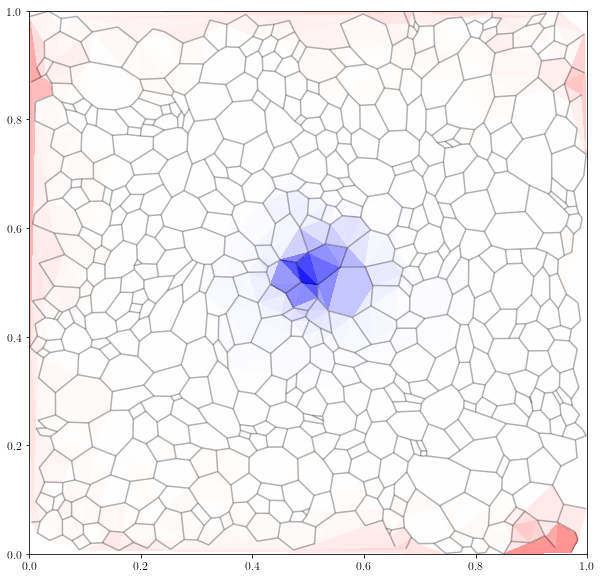

In [92]:
# find crosshair marker
from koala.lattice import Lattice
from matplotlib.colors import TwoSlopeNorm

def cmap_index(lattice, index, axis=  None):
    if axis is None:
        axis = plt.gca()
    x_vals = np.array(lattice.vertices.positions)[:,0]
    y_vals = np.array(lattice.vertices.positions)[:,1]

    norm = TwoSlopeNorm(vmin=np.min(index), vcenter=0, vmax=np.max(index))
    im = axis.tripcolor(x_vals, y_vals, index, norm= norm, cmap= 'bwr')
    return im 

positions = lattice.vertices.positions

crosshair_position = np.array([0.5,0.5])
theta_x_vec = np.diag(1*(positions[:,0] < crosshair_position[0]))
theta_y_vec = np.diag(1*(positions[:,1] < crosshair_position[1]))

X = np.diag(positions[:,0])
Y = np.diag(positions[:,1])

crosshair_marker = 4*np.pi*np.diag(P@theta_x_vec@P@theta_y_vec@P).imag
chern_marker = 4*np.pi*np.diag(P@X@P@Y@P).imag

cmap_index(lattice,crosshair_marker)
pl.plot_edges(lattice, alpha = 0.3)
plt.show()

chern number: 0.9858058756146184


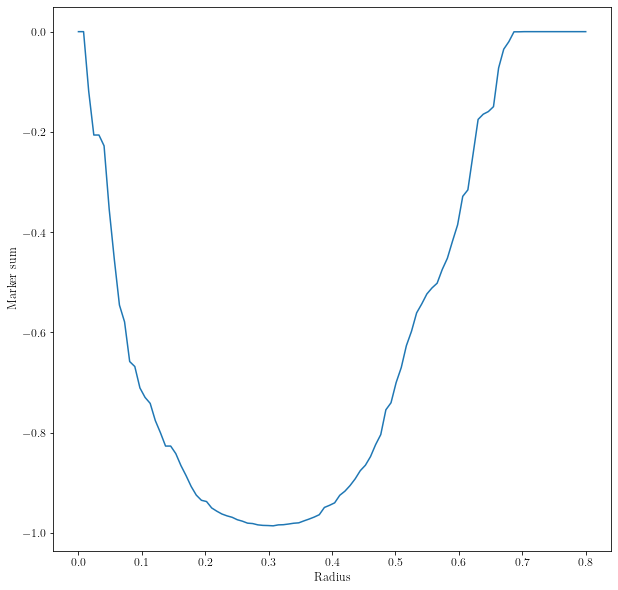

In [90]:
out = []
for radius in np.linspace(0,0.8,100):
    projector_onto_center = np.sqrt(np.sum((positions - crosshair_position)**2, axis=1))<= radius
    out.append(np.sum(projector_onto_center*cmarker))
plt.plot(np.linspace(0,0.8,100), out)
plt.xlabel('Radius')
plt.ylabel('Marker sum')

print('chern number:' , max(-np.array(out)) )